In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy.stats import ttest_rel
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# warnings.filterwarnings('ignore')

In [52]:
# 1. Carregar o dataset com separador e decimal corretos
df = pd.read_csv("../AIRPOL_data.csv", sep=";", decimal=",")

# 2. Remover colunas que foram criadas automaticamente e estão vazias (ex: "Unnamed")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# 3. Contar e remover linhas duplicadas para evitar análises repetidas ou enviesadas
duplicados = df.duplicated().sum()
print(f"\nNúmero de linhas duplicadas encontradas: {duplicados}")
if duplicados > 0:
    df = df.drop_duplicates()
    print("Linhas duplicadas removidas.")

    # Renomear coluna 'Value' para 'Premature_Deaths'
    df.rename(columns={'Value': 'Premature_Deaths'}, inplace=True)


Número de linhas duplicadas encontradas: 3600
Linhas duplicadas removidas.


In [53]:
print("Colunas do dataset:")
print(df.columns.tolist())

print("\nPrimeiras linhas do dataset:")
display(df.head())
print(f"Número de linhas: {df.shape[0]}")

Colunas do dataset:
['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']

Primeiras linhas do dataset:


,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0


Número de linhas: 45540


In [54]:
# ============================================================
# 4.3
# ALÍNEA 1 — Derive um novo atributo RespDisease que separa as doenças em respiratórias
# ('Asthma' 'Chronic obstructive pulmonary disease') e não respiratórias.
# ============================================================

# Lista de doenças respiratórias
respiratory_diseases = ['Asthma', 'Chronic obstructive pulmonary disease']

# Criar a coluna RespDisease
df['RespDisease'] = np.where(df['Outcome'].isin(respiratory_diseases), 'Respiratory', 'Non-Respiratory')
# ============================================================
# 4.3
# ALÍNEA 2 — Usando o método k-fold cross validation desenvolva modelos de previsão de
# RespDisease usando os seguintes métodos:
# a) Árvore de decisão. Otimize os parâmetros do modelo.
# b) Rede neuronal. Otimize a configuração da rede.
# c) SVM. Otimize o kernel.
# d) K-vizinhos-mais-próximos. Otimize o parâmetro K.
# ============================================================
# Mostrar quantidade de cada categoria
print("Contagem por categoria:")
print(df['RespDisease'].value_counts())

print("\nProporção por categoria:")
print(df['RespDisease'].value_counts(normalize=True))

Contagem por categoria:
RespDisease
Non-Respiratory    29317
Respiratory        16223
Name: count, dtype: int64

Proporção por categoria:
RespDisease
Non-Respiratory    0.643764
Respiratory        0.356236
Name: proportion, dtype: float64


In [55]:
# ============================================================
# 4.3
# ALÍNEA 2 — Usando o método k-fold cross validation desenvolva modelos de previsão de
# RespDisease usando os seguintes métodos:
# a) Árvore de decisão. Otimizar os parâmetros do modelo.
# b) Rede neuronal. Otimizar a configuração da rede.
# c) SVM. Otimizar o kernel.
# d) K-vizinhos-mais-próximos. Otimizar o parâmetro K.
# ============================================================

# 1. Seleção de variáveis preditoras e variável alvo
features = ['Air_Pollution_Average[ug/m3]', 'Affected_Population', 'Populated_Area[km2]']
X = df[features].copy()
y = df['RespDisease']

# Codificar variável alvo binária
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Estratégia de validação cruzada estratificada
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# 3. Função de avaliação de desempenho
def evaluate_model(model, X, y):
    acc, sens, spec, f1 = [], [], [], []
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        sens.append(tp / (tp + fn))
        spec.append(tn / (tn + fp))
    return {
        "Accuracy": (np.mean(acc), np.std(acc)),
        "Sensitivity": (np.mean(sens), np.std(sens)),
        "Specificity": (np.mean(spec), np.std(spec)),
        "F1": (np.mean(f1), np.std(f1))
    }


# 4. Espaços de pesquisa para hiperparâmetros (com base na literatura científica)
# Rokach & Maimon, 2014; Montavon et al., 2012; Cortes & Vapnik, 1995; Cover & Hart, 1967
search_spaces = {
    'Árvore de Decisão': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10]
        }
    ),
    'Rede Neuronal': (
        Pipeline([
            ('scaler', StandardScaler()),
            ('clf', MLPClassifier(max_iter=1000, random_state=42))
        ]),
        {
            'clf__hidden_layer_sizes': [(10,), (20,), (10, 10)],
            'clf__activation': ['relu', 'tanh'],
            'clf__alpha': [0.0001, 0.001, 0.01]
        }
    ),
    'SVM': (
        Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(kernel='rbf', class_weight='balanced', random_state=42))
        ]),
        {
            'clf__C': [0.1, 1.0],
            'clf__gamma': ['scale']
        }
    ),
    'K-vizinhos': (
        Pipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier())
        ]),
        {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance']
        }
    )
}

# 5. Otimização de hiperparâmetros e avaliação com validação cruzada
results = {}
best_models = {}

for nome, (model, params) in search_spaces.items():
    print(f"\n=== {nome.upper()} ===")
    print(f"A otimizar hiperparâmetros com k-fold cross validation (k={k})...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=kfold,
        n_jobs=-1 # usa todos os CPUs/transforma o PC em lava
    )
    grid.fit(X, y_encoded)
    best_model = grid.best_estimator_
    best_models[nome] = best_model

    print(f"Melhores parâmetros: {grid.best_params_}")
    print("A avaliar modelo otimizado em validação cruzada...")

    performance = evaluate_model(best_model, X, y_encoded)
    results[nome] = performance

    for metric, (mean, std) in performance.items():
        print(f"{metric}: {mean:.4f} ± {std:.4f}")

# 6. Tabela de Resultados Formatada
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.columns = ['Accuracy (mean±std)', 'Sensitivity (mean±std)', 'Specificity (mean±std)', 'F1 (mean±std)']

def format_metric(mean_std):
    mean, std = mean_std
    return f"{mean:.4f} ± {std:.4f}"

df_formatado = df_results.map(format_metric)

print("\nResumo dos resultados (média ± desvio padrão):\n")
print(df_formatado)


=== ÁRVORE DE DECISÃO ===
A otimizar hiperparâmetros com k-fold cross validation (k=5)...
Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2}
A avaliar modelo otimizado em validação cruzada...
Accuracy: 0.8863 ± 0.0011
Sensitivity: 0.6840 ± 0.0036
Specificity: 0.9983 ± 0.0004
F1: 0.8109 ± 0.0023

=== REDE NEURONAL ===
A otimizar hiperparâmetros com k-fold cross validation (k=5)...
Melhores parâmetros: {'clf__activation': 'tanh', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (10, 10)}
A avaliar modelo otimizado em validação cruzada...
Accuracy: 0.7621 ± 0.0028
Sensitivity: 0.3705 ± 0.0080
Specificity: 0.9787 ± 0.0038
F1: 0.5259 ± 0.0076

=== SVM ===
A otimizar hiperparâmetros com k-fold cross validation (k=5)...
Melhores parâmetros: {'clf__C': 1.0, 'clf__gamma': 'scale'}
A avaliar modelo otimizado em validação cruzada...
Accuracy: 0.7213 ± 0.0024
Sensitivity: 0.2181 ± 0.0070
Specificity: 0.9997 ± 0.0003
F1: 0.3580 ± 0.0094

=== K-VIZINHOS ===
A otimizar hiperparâmetros 

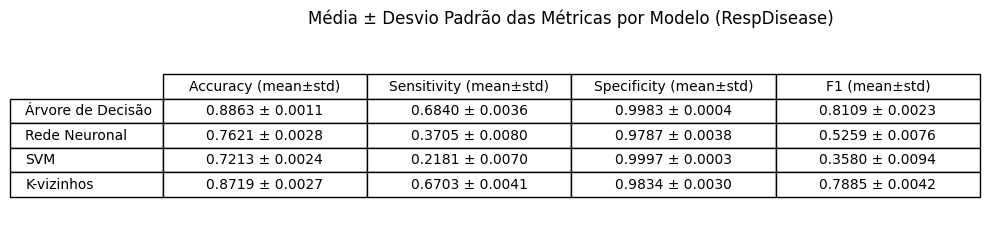

In [59]:
# ============================================================
# 4.3
# ALÍNEA 3 — Obtenha a média e o desvio padrão da Accuracy;
# Sensitivity; Specificity e F1 do atributo RespDisease com
# os modelos obtidos na alínea anterior.
# ============================================================

# Formatar métricas como "media ± std"
df_fmt = df_results.copy()
for col in df_fmt.columns:
    df_fmt[col] = df_fmt[col].apply(lambda x: f"{x[0]:.4f} ± {x[1]:.4f}")

# Gerar a tabela como imagem
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('off')
table = ax.table(
    cellText=df_fmt.values,
    colLabels=df_fmt.columns,
    rowLabels=df_fmt.index,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Média ± Desvio Padrão das Métricas por Modelo (RespDisease)", fontsize=12, pad=12)
plt.tight_layout()
plt.show()

In [61]:
# ============================================================
# 4.3
# ALÍNEA 4 — Verifique se existe diferença significativa no desempenho
# dos dois melhores modelos (nível de significância de 5%).
# ============================================================

# Hipóteses do teste estatístico:
# H0 (hipótese nula): Não existe diferença significativa entre os modelos.
# H1 (hipótese alternativa): Existe diferença significativa entre os modelos.
# Nível de significância: α = 0.05

# Utilizar os F1-scores médios previamente calculados na alínea 2 (results)
print("Avaliar F1-score médio dos modelos... ", end="")
f1_scores = {nome: resultado['F1'] for nome, resultado in results.items()}
print("feito.")

# Ordenar modelos pelo F1-score médio (posição 0 do tuplo: média)
print("Ordenar modelos pelo F1-score médio... ", end="")
sorted_f1 = sorted(f1_scores.items(), key=lambda x: x[1][0], reverse=True)
modelo_1, modelo_2 = sorted_f1[0][0], sorted_f1[1][0]
print("feito.")

print(f"Modelos selecionados para comparação: {modelo_1} vs {modelo_2}")

# Função para obter a lista de F1-scores (um por fold) — necessário para o teste estatístico
def get_f1_list(model):
    f1 = []
    for train_idx, test_idx in kfold.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1.append(f1_score(y_test, y_pred))
    return f1

# Recalcular listas de F1 por fold apenas para os dois modelos a comparar
print(f"Calcular F1-score por fold para {modelo_1}... ", end="")
f1_1 = get_f1_list(best_models[modelo_1])
print("feito.")

print(f"Calcular F1-score por fold para {modelo_2}... ", end="")
f1_2 = get_f1_list(best_models[modelo_2])
print("feito.")

# Aplicar o teste t pareado (comparação estatística entre os dois modelos)
print("Executar teste t pareado... ", end="")
stat, p_value = ttest_rel(f1_1, f1_2)
print("feito.")

# Resultado e interpretação
print(f"p-value = {p_value:.4f}")

# Se p-value < 0.05 -> há evidência suficiente para rejeitar a hipótese nula.
if p_value < 0.05:
    print("Conclusão: diferença estatisticamente significativa.")
    melhor = modelo_1 if np.mean(f1_1) > np.mean(f1_2) else modelo_2
    print(f"Modelo com melhor desempenho: {melhor}")
else:
    print("Conclusão: não há diferença estatisticamente significativa entre os dois modelos.")


Avaliar F1-score médio dos modelos... feito.
Ordenar modelos pelo F1-score médio... feito.
Modelos selecionados para comparação: Árvore de Decisão vs K-vizinhos
Calcular F1-score por fold para Árvore de Decisão... feito.
Calcular F1-score por fold para K-vizinhos... feito.
Executar teste t pareado... feito.
p-value = 0.0001
Conclusão: diferença estatisticamente significativa.
Modelo com melhor desempenho: Árvore de Decisão


In [62]:
# ============================================================
# 4.3
# ALÍNEA 5 — Compare os resultados dos modelos.
# Discuta qual apresentou melhor e pior desempenho em:
# Accuracy, Sensitivity, Specificity e F1.
# ============================================================

# Extrair média de cada métrica para comparação
metricas = df_results.copy()
for coluna in metricas.columns:
    metricas[coluna] = metricas[coluna].apply(lambda x: x[0])  # só a média, ignora std

# Identificar o melhor e pior modelo por métrica
for metrica in metricas.columns:
    melhor_modelo = metricas[metrica].idxmax()
    pior_modelo = metricas[metrica].idxmin()
    valor_melhor = metricas[metrica].max()
    valor_pior = metricas[metrica].min()

    print(f"{metrica}:")
    print(f"  Melhor desempenho -> {melhor_modelo} ({valor_melhor:.4f})")
    print(f"  Pior desempenho   -> {pior_modelo} ({valor_pior:.4f})\n")


Accuracy (mean±std):
  Melhor desempenho -> Árvore de Decisão (0.8863)
  Pior desempenho   -> SVM (0.7213)

Sensitivity (mean±std):
  Melhor desempenho -> Árvore de Decisão (0.6840)
  Pior desempenho   -> SVM (0.2181)

Specificity (mean±std):
  Melhor desempenho -> SVM (0.9997)
  Pior desempenho   -> Rede Neuronal (0.9787)

F1 (mean±std):
  Melhor desempenho -> Árvore de Decisão (0.8109)
  Pior desempenho   -> SVM (0.3580)



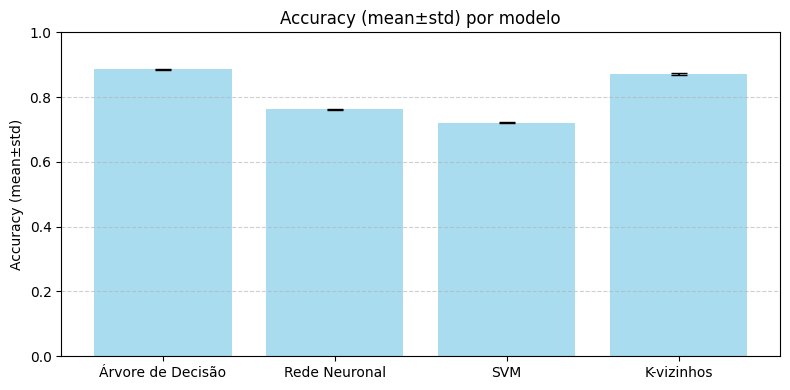

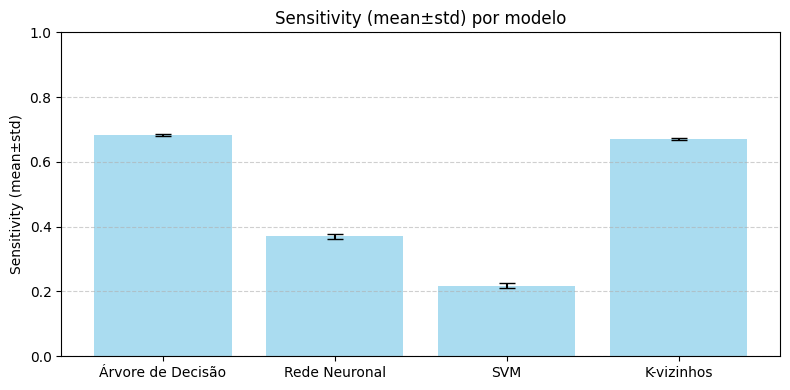

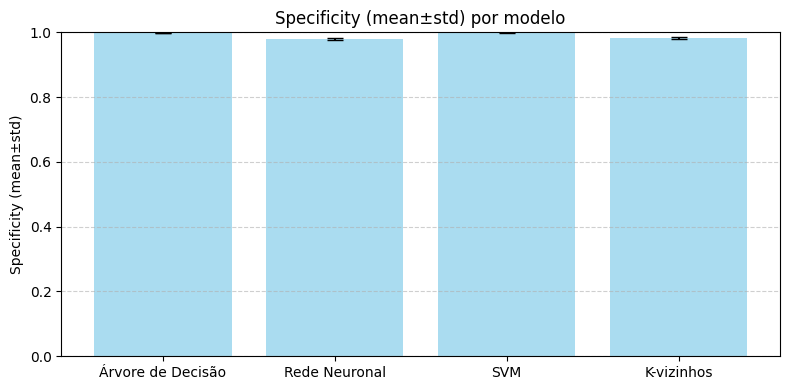

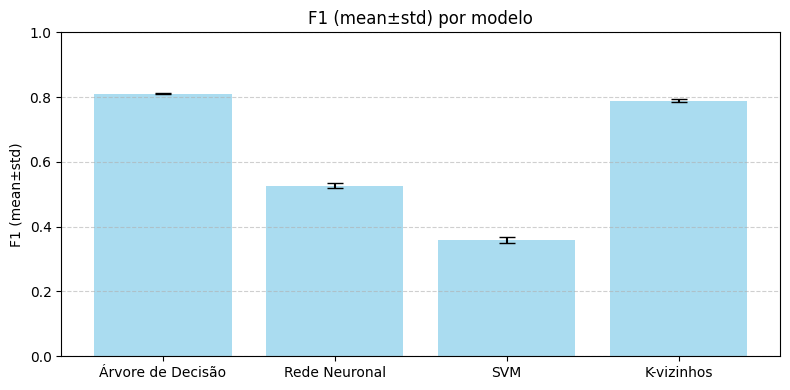

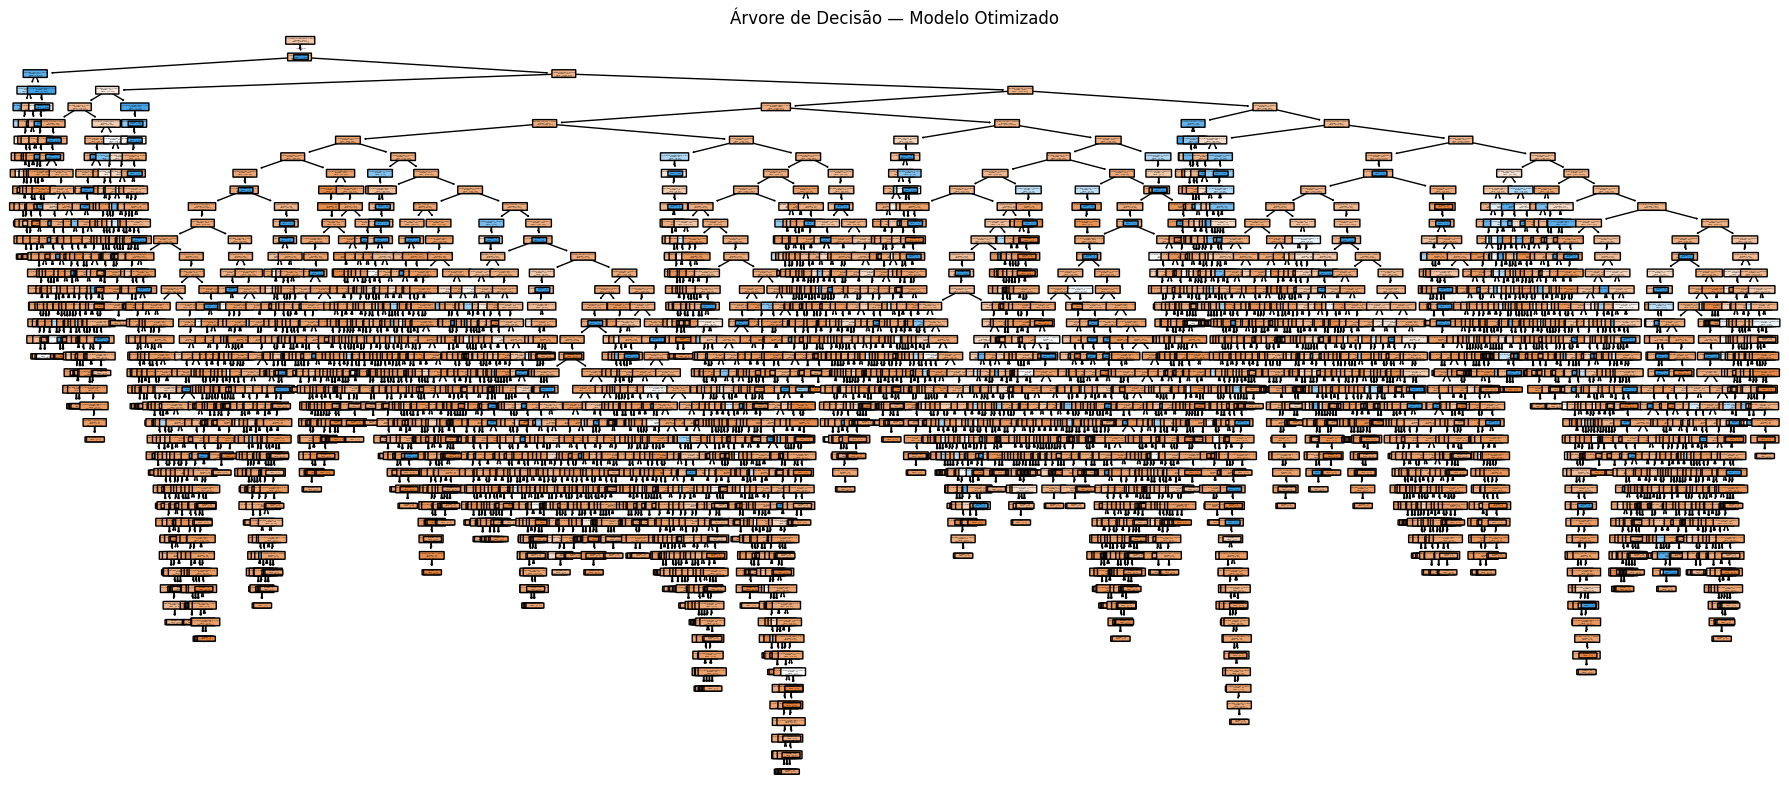

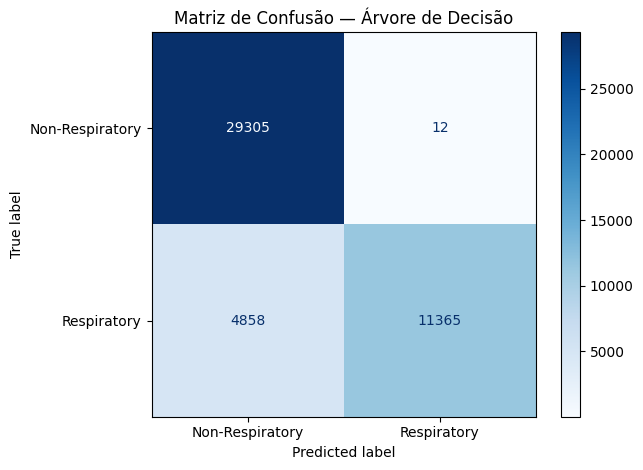

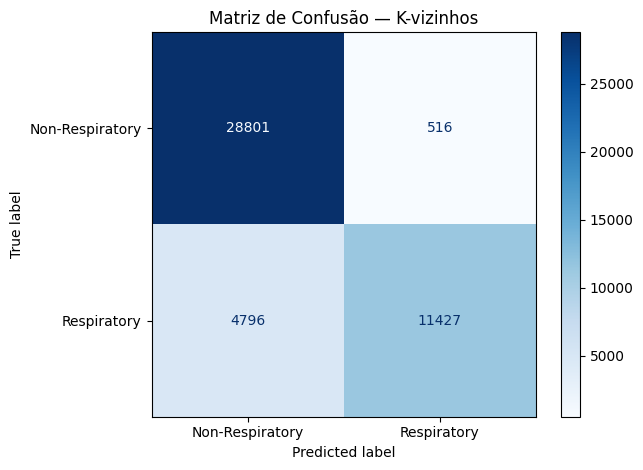

In [64]:
# ============================================================
# 4.3
# GRÁFICOS
# - Accuracy
# - Sensitivity
# - Specificity
# - F1-score
# - Decision Tree Plot
# - Confusion Matrix Heatmap
# ============================================================

# Gráficos de barras para cada métrica
metricas = ['Accuracy (mean±std)', 'Sensitivity (mean±std)', 'Specificity (mean±std)', 'F1 (mean±std)']

# Para cada métrica, gerar um gráfico de barras
for metrica in metricas:
    means = df_results[metrica].apply(lambda x: x[0])
    stds = df_results[metrica].apply(lambda x: x[1])

    plt.figure(figsize=(8, 4))
    plt.bar(means.index, means.values, yerr=stds.values, capsize=6, alpha=0.7, color='skyblue')
    plt.title(f"{metrica} por modelo")
    plt.ylabel(metrica)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Árvore de Decisão (plot da estrutura da árvore)
plt.figure(figsize=(18, 8))
plot_tree(
    best_models['Árvore de Decisão'],
    feature_names=features,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    impurity=False
)
plt.title("Árvore de Decisão — Modelo Otimizado")
plt.tight_layout()
plt.show()

# Matriz de Confusão — Árvore de Decisão (sem normalizar)
y_pred_tree = best_models['Árvore de Decisão'].predict(X)
disp_tree = ConfusionMatrixDisplay.from_predictions(
    y_encoded,
    y_pred_tree,
    display_labels=le.classes_,
    cmap='Blues',
    #normalize='true' # comentar para valores absolutos
)
disp_tree.ax_.set_title("Matriz de Confusão — Árvore de Decisão")
plt.tight_layout()
plt.show()

# Matriz de Confusão — K-vizinhos (sem normalizar)
y_pred_knn = best_models['K-vizinhos'].predict(X)
disp_knn = ConfusionMatrixDisplay.from_predictions(
    y_encoded,
    y_pred_knn,
    display_labels=le.classes_,
    cmap='Blues',
    #normalize='true' # comentar para valores absolutos
)
disp_knn.ax_.set_title("Matriz de Confusão — K-vizinhos")
plt.tight_layout()
plt.show()